# ✅ QC Visual Checklist
- [ ] Subject/story availability table + bar plot
- [ ] Story n_TR histogram
- [ ] Stimulus overlays (2 stories)
- [ ] Envelope vs word-rate scatter
- [ ] Words per TR histogram
- [ ] Cross-correlation preview (if ≥100 TR)
- [ ] Volatility bars


In [1]:
import sys
from pathlib import Path
REPO_ROOT = Path.cwd().parent  # resolves to /flash/PaoU/seann/fmri-edm-ccm
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


In [2]:
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from src.io_ds003020 import list_subjects, list_stories_for_subject
from src.qc_viz import (
    HAVE_AUDIO,
    HAVE_TEXTGRID,
    ensure_dir,
    load_driver_series,
    summarize_story,
    select_story_samples,
    normalize,
    pearsonr_safe,
    story_cross_correlation,
)

TR = 2.0
DATA_ROOT = Path('/bucket/PaoU/seann/openneuro/ds003020')
QC_DIR = ensure_dir(REPO_ROOT / 'derivatives' / 'results' / 'qc')
SUMMARY_CSV = REPO_ROOT / 'derivatives' / 'results' / 'summary_day1_all.csv'

plt.style.use('default')
plt.rcParams.update({'figure.figsize': (8, 4)})


def save_and_show(fig, filename: str) -> None:
    out_path = QC_DIR / filename
    fig.savefig(out_path, dpi=150, bbox_inches='tight')
    display(fig)
    plt.close(fig)
    print(f'Saved {out_path}')



,subject,story_id,session,run,has_textgrid
0,sub-UTS01,shoppinginchina,ses-7,None,True
1,sub-UTS01,treasureisland,ses-7,None,True
2,sub-UTS01,penpal,ses-7,None,True
3,sub-UTS01,wheretheressmoke,ses-7,6,True
4,sub-UTS01,onlyonewaytofindout,ses-7,None,True


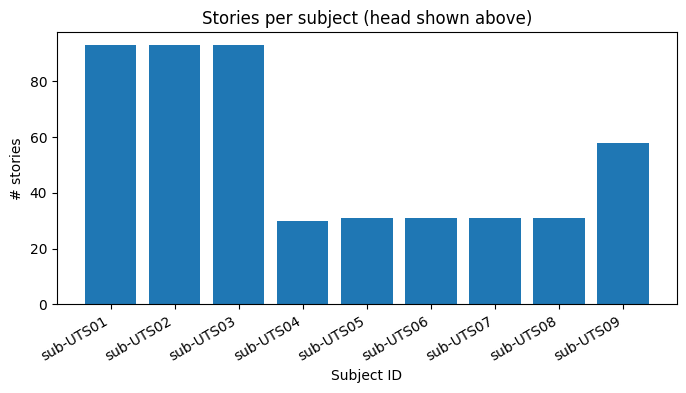

Saved /flash/PaoU/seann/fmri-edm-ccm/derivatives/results/qc/all_subjects_story_counts.png


In [3]:
subject_ids: List[str] = list_subjects(DATA_ROOT)
story_records = []
for subj in subject_ids:
    story_records.extend(list_stories_for_subject(DATA_ROOT, subj))

story_df = pd.DataFrame(story_records)
if story_df.empty:
    print('No stories found under DATA_ROOT; aborting QC visuals.')
else:
    story_df['has_textgrid'] = story_df['textgrid'].notna()
    display(story_df[['subject', 'story_id', 'session', 'run', 'has_textgrid']].head())

    counts = story_df.groupby('subject')['story_id'].count().sort_index()
    fig, ax = plt.subplots()
    ax.bar(counts.index, counts.values)
    ax.set_title('Stories per subject (head shown above)')
    ax.set_xlabel('Subject ID')
    ax.set_ylabel('# stories')
    fig.autofmt_xdate(rotation=30)
    save_and_show(fig, 'all_subjects_story_counts.png')



In [4]:
driver_cache = {}
summary_df = pd.DataFrame()

if story_df.empty:
    print('Story table empty; downstream visuals will be skipped.')
elif not HAVE_AUDIO or not HAVE_TEXTGRID:
    print(f'Skipping driver summaries (HAVE_AUDIO={HAVE_AUDIO}, HAVE_TEXTGRID={HAVE_TEXTGRID}).')
else:
    rows = []
    for rec in story_df.to_dict('records'):
        wav_path = Path(rec['wav']) if rec.get('wav') else None
        tg_path = Path(rec['textgrid']) if rec.get('textgrid') else None
        if wav_path is None or not wav_path.exists():
            print(f"Skip {rec['subject']} | {rec['story_id']} : missing WAV")
            continue
        try:
            drivers = load_driver_series(wav_path, tg_path, tr=TR)
        except Exception as exc:
            print(f"Skip {rec['subject']} | {rec['story_id']} : {exc}")
            continue
        driver_cache[(rec['subject'], rec['story_id'])] = drivers
        rows.append(summarize_story(rec, drivers))

    summary_df = pd.DataFrame(rows)
    if summary_df.empty:
        print('Summary table is empty after processing stories.')
    else:
        summary_df['brain_n_tr'] = np.nan
        SUMMARY_CSV.parent.mkdir(parents=True, exist_ok=True)
        summary_df.to_csv(SUMMARY_CSV, index=False)
        print(f'Summary stats saved to {SUMMARY_CSV}')

summary_df.head()



Skip sub-UTS01 | theshower : (Interval(22.42154, 24.23742, sp), Interval(24.23741, 24.29728, N))
Skip sub-UTS01 | legacy : The file could not be parsed as a Praat text file as it is lacking a proper header.
Skip sub-UTS01 | exorcism : The file could not be parsed as a Praat text file as it is lacking a proper header.
Skip sub-UTS01 | food : (Interval(618.22744, 622.78708, lg), Interval(622.78707, 623.06644, S))
Skip sub-UTS01 | haveyoumethimyet : (Interval(577.77937, 579.34581, lg), Interval(579.3458, 580.45329, sp))
Skip sub-UTS02 | theshower : (Interval(22.42154, 24.23742, sp), Interval(24.23741, 24.29728, N))
Skip sub-UTS02 | legacy : The file could not be parsed as a Praat text file as it is lacking a proper header.
Skip sub-UTS02 | exorcism : The file could not be parsed as a Praat text file as it is lacking a proper header.
Skip sub-UTS02 | food : (Interval(618.22744, 622.78708, lg), Interval(622.78707, 623.06644, S))
Skip sub-UTS02 | haveyoumethimyet : (Interval(577.77937, 579.3

,subject,story_id,session,run,n_tr,env_mean,env_sd,env_max,word_count,words_per_tr,wordrate_mean,wordrate_sd,brain_n_tr
0,sub-UTS01,shoppinginchina,ses-7,None,348,0.085410,0.034426,0.274052,2365.0,6.795977,6.795977,2.173848,NaN
1,sub-UTS01,treasureisland,ses-7,None,405,0.032145,0.018017,0.106832,2548.0,6.291358,6.291358,2.380798,NaN
2,sub-UTS01,penpal,ses-7,None,266,0.068106,0.016676,0.111882,2167.0,8.146617,8.146617,2.128646,NaN
3,sub-UTS01,wheretheressmoke,ses-7,6,301,0.026322,0.016355,0.152549,2608.0,8.664452,8.664452,2.690644,NaN
4,sub-UTS01,onlyonewaytofindout,ses-7,None,393,0.036900,0.017932,0.092908,2616.0,6.656489,6.656489,2.657088,NaN


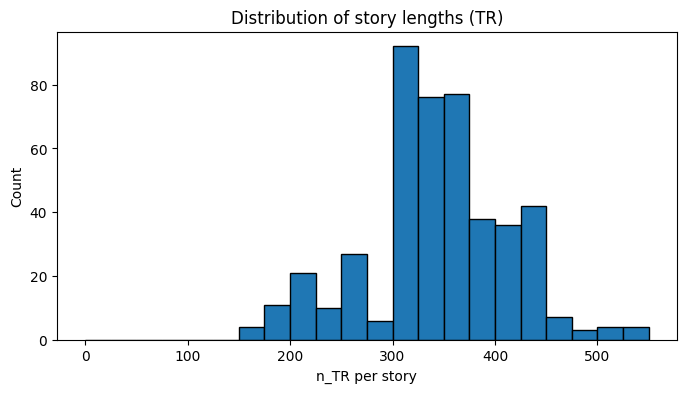

Saved /flash/PaoU/seann/fmri-edm-ccm/derivatives/results/qc/all_stories_ntr_hist.png


In [5]:
if summary_df.empty:
    print('Skipping n_TR histogram: summary table empty.')
else:
    bins = np.arange(0, summary_df['n_tr'].max() + 25, 25)
    if bins.size < 2:
        bins = 10
    fig, ax = plt.subplots()
    ax.hist(summary_df['n_tr'], bins=bins, color='C0', edgecolor='black')
    ax.set_title('Distribution of story lengths (TR)')
    ax.set_xlabel('n_TR per story')
    ax.set_ylabel('Count')
    save_and_show(fig, 'all_stories_ntr_hist.png')



In [6]:
overlay_targets = []
if summary_df.empty:
    print('No summaries available for overlay selection.')
else:
    sample_indices = select_story_samples(summary_df, n=min(2, len(summary_df)))
    overlay_targets = summary_df.iloc[sample_indices].reset_index(drop=True)
    display(overlay_targets[['subject', 'story_id', 'n_tr']])



,subject,story_id,n_tr
0,sub-UTS01,shoppinginchina,348
1,sub-UTS09,eyespy,390


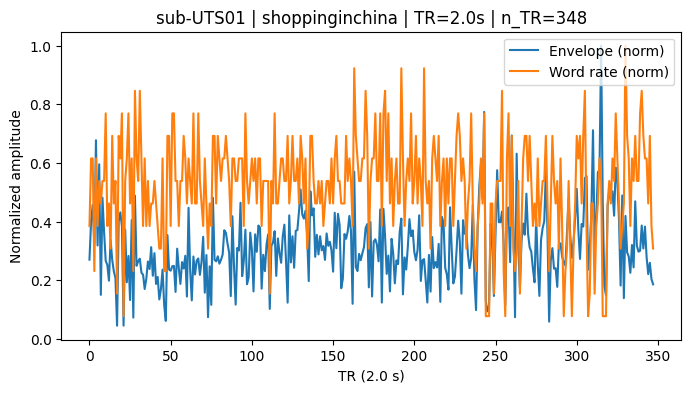

Saved /flash/PaoU/seann/fmri-edm-ccm/derivatives/results/qc/sub-UTS01_shoppinginchina_overlay.png


In [7]:
target_idx = 0
if overlay_targets is None or len(overlay_targets) <= target_idx:
    print('No overlay target available for this slot.')
else:
    rec = overlay_targets.loc[target_idx]
    drivers = driver_cache.get((rec['subject'], rec['story_id']))
    if drivers is None or drivers.word_rate is None:
        print(f"Skipping overlay for {rec['subject']} | {rec['story_id']} (missing drivers).")
    else:
        env_norm = normalize(drivers.envelope)
        rate_norm = normalize(drivers.word_rate)
        fig, ax = plt.subplots()
        ax.plot(env_norm, label='Envelope (norm)')
        ax.plot(rate_norm, label='Word rate (norm)')
        ax.set_xlabel('TR (2.0 s)')
        ax.set_ylabel('Normalized amplitude')
        ax.set_title(f"{rec['subject']} | {rec['story_id']} | TR=2.0s | n_TR={int(rec['n_tr'])}")
        ax.legend(loc='upper right')
        filename = f"{rec['subject']}_{rec['story_id']}_overlay.png"
        save_and_show(fig, filename)



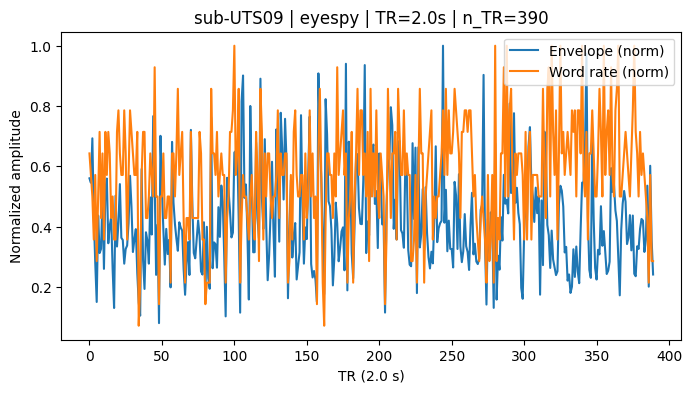

Saved /flash/PaoU/seann/fmri-edm-ccm/derivatives/results/qc/sub-UTS09_eyespy_overlay.png


In [8]:
target_idx = 1
if overlay_targets is None or len(overlay_targets) <= target_idx:
    print('No overlay target available for this slot.')
else:
    rec = overlay_targets.loc[target_idx]
    drivers = driver_cache.get((rec['subject'], rec['story_id']))
    if drivers is None or drivers.word_rate is None:
        print(f"Skipping overlay for {rec['subject']} | {rec['story_id']} (missing drivers).")
    else:
        env_norm = normalize(drivers.envelope)
        rate_norm = normalize(drivers.word_rate)
        fig, ax = plt.subplots()
        ax.plot(env_norm, label='Envelope (norm)')
        ax.plot(rate_norm, label='Word rate (norm)')
        ax.set_xlabel('TR (2.0 s)')
        ax.set_ylabel('Normalized amplitude')
        ax.set_title(f"{rec['subject']} | {rec['story_id']} | TR=2.0s | n_TR={int(rec['n_tr'])}")
        ax.legend(loc='upper right')
        filename = f"{rec['subject']}_{rec['story_id']}_overlay.png"
        save_and_show(fig, filename)



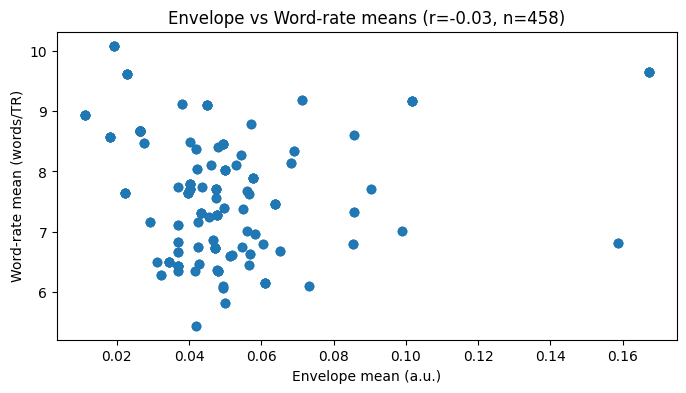

Saved /flash/PaoU/seann/fmri-edm-ccm/derivatives/results/qc/all_stories_env_vs_wordrate_scatter.png


In [9]:
if summary_df.empty:
    print('Skipping scatter: summary table empty.')
else:
    valid = summary_df.dropna(subset=['env_mean', 'wordrate_mean'])
    if valid.empty:
        print('Skipping scatter: no stories with both envelope and word-rate stats.')
    else:
        r_val = pearsonr_safe(valid['env_mean'].values, valid['wordrate_mean'].values)
        fig, ax = plt.subplots()
        ax.scatter(valid['env_mean'], valid['wordrate_mean'], alpha=0.7)
        ax.set_xlabel('Envelope mean (a.u.)')
        ax.set_ylabel('Word-rate mean (words/TR)')
        ax.set_title(f'Envelope vs Word-rate means (r={r_val:.2f}, n={len(valid)})')
        save_and_show(fig, 'all_stories_env_vs_wordrate_scatter.png')



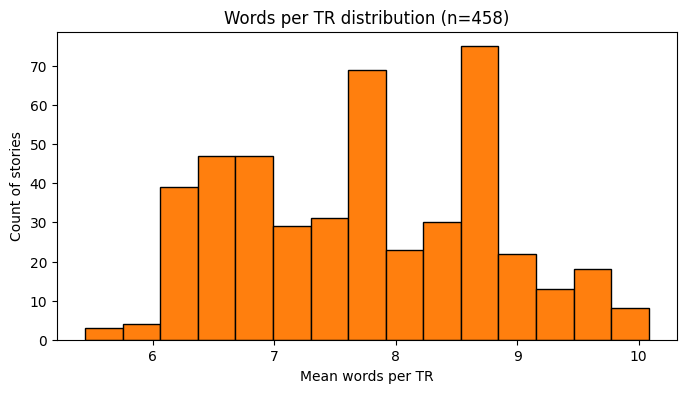

Saved /flash/PaoU/seann/fmri-edm-ccm/derivatives/results/qc/all_stories_words_per_tr_hist.png


In [10]:
if summary_df.empty:
    print('Skipping words/TR histogram: summary table empty.')
else:
    word_rates = summary_df['words_per_tr'].dropna()
    if word_rates.empty:
        print('Skipping words/TR histogram: no word-rate data.')
    else:
        fig, ax = plt.subplots()
        ax.hist(word_rates, bins=15, color='C1', edgecolor='black')
        ax.set_xlabel('Mean words per TR')
        ax.set_ylabel('Count of stories')
        ax.set_title(f'Words per TR distribution (n={len(word_rates)})')
        save_and_show(fig, 'all_stories_words_per_tr_hist.png')



In [11]:
print('Brain TR counts unavailable; skipping alignment QC (NA brain).')


Brain TR counts unavailable; skipping alignment QC (NA brain).


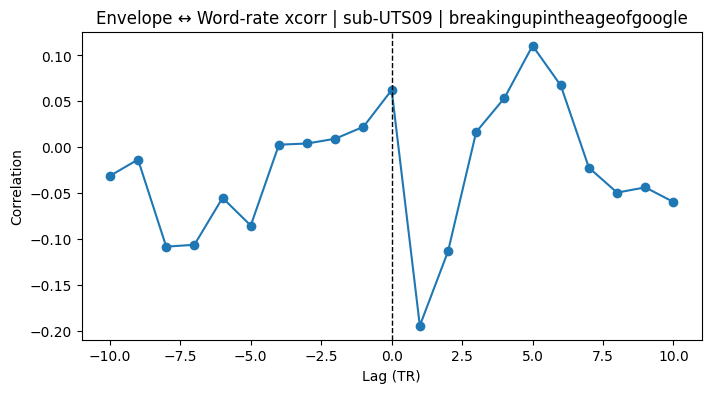

Saved /flash/PaoU/seann/fmri-edm-ccm/derivatives/results/qc/sub-UTS09_breakingupintheageofgoogle_xcorr.png


In [12]:
if summary_df.empty:
    print('Skipping cross-correlation: summary table empty.')
else:
    target = summary_df.sort_values('n_tr', ascending=False).head(1)
    if target.empty:
        print('Skipping cross-correlation: no target story.')
    else:
        rec = target.iloc[0]
        drivers = driver_cache.get((rec['subject'], rec['story_id']))
        if drivers is None or drivers.word_rate is None or drivers.n_tr < 100:
            print('Skipping cross-correlation: insufficient length or missing word-rate.')
        else:
            try:
                lags, corrs = story_cross_correlation(drivers.envelope, drivers.word_rate, max_lag=10)
            except ValueError as exc:
                print(f'Skipping cross-correlation: {exc}')
            else:
                fig, ax = plt.subplots()
                ax.plot(lags, corrs, marker='o')
                ax.axvline(0, color='black', linewidth=1, linestyle='--')
                ax.set_xlabel('Lag (TR)')
                ax.set_ylabel('Correlation')
                ax.set_title(f"Envelope ↔ Word-rate xcorr | {rec['subject']} | {rec['story_id']}")
                save_and_show(fig, f"{rec['subject']}_{rec['story_id']}_xcorr.png")



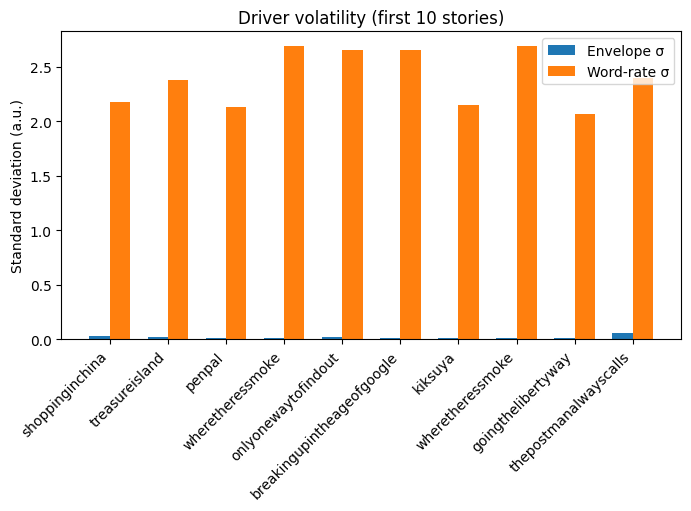

Saved /flash/PaoU/seann/fmri-edm-ccm/derivatives/results/qc/sample_stories_volatility.png


In [13]:
if summary_df.empty:
    print('Skipping volatility plot: summary table empty.')
else:
    sample = summary_df.dropna(subset=['env_sd', 'wordrate_sd']).head(10)
    if sample.empty:
        print('Skipping volatility plot: insufficient driver stats.')
    else:
        x = np.arange(len(sample))
        width = 0.35
        fig, ax = plt.subplots()
        ax.bar(x - width / 2, sample['env_sd'], width, label='Envelope σ')
        ax.bar(x + width / 2, sample['wordrate_sd'], width, label='Word-rate σ')
        ax.set_xticks(x)
        ax.set_xticklabels(sample['story_id'], rotation=45, ha='right')
        ax.set_ylabel('Standard deviation (a.u.)')
        ax.set_title('Driver volatility (first 10 stories)')
        ax.legend()
        save_and_show(fig, 'sample_stories_volatility.png')

